In [26]:
import sys
import os

path = os.getcwd()

from collections import Counter

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import scipy.stats
from scipy.stats import binned_statistic_2d

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import Pipeline

matplotlib.rcParams.update({'xtick.labelsize': 16})
matplotlib.rcParams.update({'ytick.labelsize': 16})

In [27]:
# Read in the csv file
df = pd.read_csv(path + '/' + 'haberman.data.csv')

In [28]:
data = df.values

# split into input and output elements
X, y = data[:, :-1], data[:, -1]

# label encode the target variable to have the classes 0 and 1
y = LabelEncoder().fit_transform(y)


In [29]:
# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):
    # calculate reference brier score
    ref_probs = [per_pos for _ in range(len(y_true))]
    bs_ref = brier_score_loss(y_true, ref_probs)
    # calculate model brier score
    bs_model = brier_score_loss(y_true, y_prob)
    # calculate skill score
    print(1.0 - (bs_model / bs_ref))
    return 1.0 - (bs_model / bs_ref)


In [30]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(brier_skill_score, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores


In [31]:
# fit the model
model = Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m',LogisticRegression(solver='lbfgs'))])
model.fit(X, y)

print('Model fit complete.')


Model fit complete.


In [32]:
age = float(input('What was the age of the patient at the time of the operation?: '))
year = float(input('In what year was the surgery performed?: ')) - 1900.0
nodes = float(input('How many positive axillary nodes were detected in the patient?: '))
# some new cases
data = [[age,year,nodes]]
for row in data:
    # make prediction
    yhat = model.predict_proba([row])
    # get percentage of survival
    p_survive = yhat[0, 0] * 100
    # summarize
    print('\n')
    print('\n')
    print('A {0:.0f}-year-old patient undergoing the breast cancer surgery in {1:.0f}'.format(age, year + 1900.0))
    print('with {0:.0f} positive axillary nodes detected has a {1:.2f}% chance of long-term survival.'.format(nodes, p_survive))
    

What was the age of the patient at the time of the operation?: 26
In what year was the surgery performed?: 1966
How many positive axillary nodes were detected in the patient?: 5




A 26-year-old patient undergoing the breast cancer surgery in 1966
with 5 positive axillary nodes detected has a 77.12% chance of long-term survival.


In [35]:
print('Test Cases:')
data = [[66,58,0], [52,69,3], [36,60,1], [38,60,0], [53,59,3]] #1,2,1,1,2 
for row in data:
    # make prediction
    yhat = model.predict_proba([row])
    # get percentage of survival
    p_survive = yhat[0, 0] * 100
    # summarize
    print('data=%s, Survival=%.3f%%' % (row, p_survive))
    

Test Cases:
data=[66, 58, 0], Survival=81.007%
data=[52, 69, 3], Survival=71.216%
data=[36, 60, 1], Survival=86.104%
data=[38, 60, 0], Survival=89.827%
data=[53, 59, 3], Survival=68.343%


In [33]:
ages = np.arange(np.min(df['AGE']), np.max(df['AGE'])+1, 1)
years = np.arange(np.min(df['YEAR']), np.max(df['YEAR'])+1, 1)
nodes = np.arange(np.min(df['NODES']), np.max(df['NODES'])+1, 1)

prob = []
for i,a in enumerate(ages):
    for j,y in enumerate(years):
        for k,n in enumerate(nodes):
            row = [a,y,k]
            yhat = model.predict_proba([row])
            p_survive = yhat[0, 0] * 100
            
            prob.append([a,y,k,p_survive/100.0])

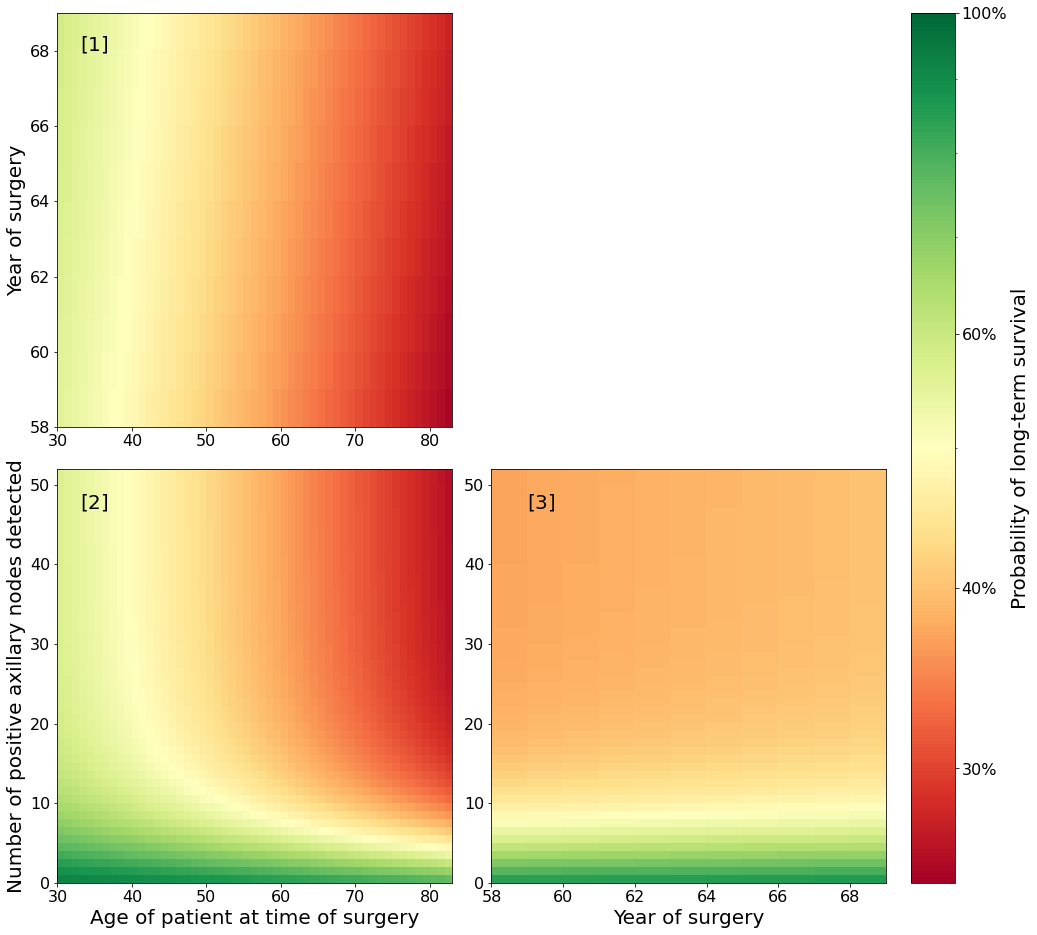

In [34]:
fig, axarr = plt.subplots(2,2, figsize=(18,16))

fig.subplots_adjust(wspace=0.1,hspace=0.1)

ages_model = []
year_model = []
node_model = []
prob_model = []
for i,p in enumerate(prob):
    ages_model.append(p[0])
    year_model.append(p[1])
    node_model.append(p[2])
    prob_model.append(p[3])

ret_ay = binned_statistic_2d(ages_model, year_model, prob_model, statistic=np.median, bins=[ages, years])
im = axarr[0,0].imshow(ret_ay.statistic.T, origin='bottom', 
                       cmap='RdYlGn', aspect='auto', extent=(np.min(ages), np.max(ages), np.min(years), np.max(years)),
                       vmin=0.25, vmax=1.0, norm=matplotlib.colors.LogNorm())
axarr[0,0].text(33,68,'$[1]$',fontsize=20)

ret_an = binned_statistic_2d(ages_model, node_model, prob_model, statistic=np.median, bins=[ages, nodes])
axarr[1,0].imshow(ret_an.statistic.T, origin='bottom', 
                       cmap='RdYlGn', aspect='auto', extent=(np.min(ages), np.max(ages), np.min(nodes), np.max(nodes)),
                       vmin=0.25, vmax=1.0, norm=matplotlib.colors.LogNorm())
axarr[1,0].text(33,47,'$[2]$',fontsize=20)
    
ret_yn = binned_statistic_2d(year_model, node_model, prob_model, statistic=np.median, bins=[years, nodes])
axarr[1,1].imshow(ret_yn.statistic.T, origin='bottom', 
                       cmap='RdYlGn', aspect='auto', extent=(np.min(years), np.max(years), np.min(nodes), np.max(nodes)),
                       vmin=0.25, vmax=1.0, norm=matplotlib.colors.LogNorm())
axarr[1,1].text(59,47,'$[3]$',fontsize=20)

axarr[0,1].axis('off')

axarr[0,0].set_ylabel('Year of surgery',fontsize=20)
axarr[1,0].set_xlabel('Age of patient at time of surgery',fontsize=20)
axarr[1,0].set_ylabel('Number of positive axillary nodes detected',fontsize=20)
axarr[1,1].set_xlabel('Year of surgery',fontsize=20)

cbar = fig.colorbar(im, ax=axarr.ravel().tolist(), ticks=[0.3, 0.4, 0.6, 1.0], pad=0.025)
cbar.set_label(label='Probability of long-term survival', fontsize=20)
cbar.ax.set_yticklabels(['30%', '40%', '60%', '100%'])

plt.savefig(path + '/' + 'haberman_corner_survival.pdf', fig=fig, dpi=300)
